# chack periodicity V1.0

In [ ]:
import numpy as np
import pandas as pd

def detect_steady_state(csv_file, target_freq, sampling_rate=100000, 
                       check_points=5, threshold= 1e-3):
    """
    檢測VM通道數據的穩態起始點
    
    Parameters:
    ----------
    csv_file : str, CSV檔案路徑
    target_freq : float, 目標頻率 (Hz)
    sampling_rate : int, 取樣頻率 (預設100kHz)
    check_points : int, 每週期檢查點數 (預設5點)
    threshold : float, 穩態判斷閾值 (預設1e-3)
    
    Returns:
    -------
    int: 建議的穩態起始index (原始數據index)
    """
    
    print(f"分析: {csv_file}, 目標頻率: {target_freq} Hz")
    
    # === 步驟1: 載入數據並排除錯誤點 ===
    df = pd.read_csv(csv_file)
    
    # 排除每10000個點 (0, 10000, 20000, ...)
    exclude_indices = np.arange(0, len(df), 10000)
    valid_mask = np.ones(len(df), dtype=bool)
    valid_mask[exclude_indices] = False
    
    # 提取有效VM數據
    valid_df = df[valid_mask].reset_index(drop=True)
    vm_data = valid_df[['vm_0', 'vm_1', 'vm_2', 'vm_3', 'vm_4', 'vm_5']].values.T
    original_indices = np.where(valid_mask)[0]
    
    print(f"有效數據點: {len(valid_df)} (排除 {len(exclude_indices)} 個錯誤點)")
    
    # === 步驟2: 計算週期參數 ===
    period_samples = int(sampling_rate / target_freq)
    max_periods = len(valid_df) // period_samples
    check_positions = np.linspace(0, period_samples-1, check_points, dtype=int)
    
    print(f"週期長度: {period_samples} 樣本, 可分析週期數: {max_periods}")
    
    # === 步驟3: 逐通道檢測穩態 ===
    steady_indices = []
    
    for vm_ch in range(6):
        signal = vm_data[vm_ch]
        steady_idx = None
        
        # 從第2個週期開始檢查 (跳過瞬態)
        for period_num in range(1, max_periods-1):
            current_start = period_num * period_samples
            next_start = (period_num + 1) * period_samples
            
            # 檢查週期內對應點的差值
            max_diff = 0
            for pos in check_positions:
                current_val = signal[current_start + pos]
                next_val = signal[next_start + pos]
                diff = abs(current_val - next_val)
                max_diff = max(max_diff, diff)
            
            # 判斷是否進入穩態
            if max_diff < threshold:
                steady_idx = current_start
                break
        
        if steady_idx is not None:
            original_steady_idx = original_indices[steady_idx]
            steady_indices.append(original_steady_idx)
            print(f"VM_{vm_ch}: 穩態@index {original_steady_idx} (差值:{max_diff:.2e})")
        else:
            print(f"VM_{vm_ch}: 未檢測到穩態")
    
    # === 步驟4: 綜合判斷 ===
    if steady_indices:
        recommended_idx = max(steady_indices)  # 最保守策略
        print(f"\n建議穩態起始點: index {recommended_idx}")
        return recommended_idx
    else:
        print(f"\n警告: 所有通道均未檢測到穩態!")
        return None

# === 使用範例 ===
if __name__ == "__main__":
    # 測試你的數據
    csv_file = "3.csv"  # 替換為你的檔案名
    target_freq = 10    # 10Hz激勵
    check_points = 10  
    threshold = 1e-3  # 穩態判斷閾值
    
    steady_start_idx = detect_steady_state(csv_file, target_freq,check_points=check_points, threshold=threshold)
    
    if steady_start_idx:
        print(f"\n結論: 從index {steady_start_idx} 開始取數據進行B矩陣計算")
    else:
        print(f"\n結論: 建議調整參數或檢查數據品質")

# chack periodicity : mult cycle & period in units V2.0

In [ ]:
import numpy as np
import pandas as pd

def detect_steady_state_by_periods(csv_file, target_freq, sampling_rate=100000,
                                 start_period=1, consecutive_periods=1, 
                                 check_points=5, threshold=1e-3):
    """
    以週期為單位檢測穩態
    
    Parameters:
    ----------
    csv_file : str, CSV檔案路徑
    target_freq : float, 目標頻率 (Hz)
    sampling_rate : int, 取樣頻率 (預設100kHz)
    start_period : int, 開始檢測的週期號 (預設第1週期)
    consecutive_periods : int, 要求連續穩定的週期數 (預設1個週期)
    check_points : int, 每週期檢查點數 (預設5點)
    threshold : float, 穩態判斷閾值 (預設1e-3)
    
    Returns:
    -------
    dict: {'period': int, 'index': int} 或 None
    """
    
    print(f"分析: {csv_file}, 連續{consecutive_periods}週期穩定檢測")
    
    # === 載入數據並排除錯誤點 ===
    df = pd.read_csv(csv_file)
    exclude_indices = np.arange(0, len(df), 10000)
    valid_mask = np.ones(len(df), dtype=bool)
    valid_mask[exclude_indices] = False
    
    valid_df = df[valid_mask].reset_index(drop=True)
    vm_data = valid_df[['vm_0', 'vm_1', 'vm_2', 'vm_3', 'vm_4', 'vm_5']].values.T
    original_indices = np.where(valid_mask)[0]
    
    # === 計算週期參數 ===
    period_samples = int(sampling_rate / target_freq)
    max_periods = len(valid_df) // period_samples
    check_positions = np.linspace(0, period_samples-1, check_points, dtype=int)
    
    print(f"總週期數: {max_periods}, 每週期{period_samples}樣本")
    
    # === 檢測各通道穩態 ===
    steady_periods = []
    
    for vm_ch in range(6):
        signal = vm_data[vm_ch]
        steady_period = find_channel_steady_period(
            signal, period_samples, max_periods, check_positions,
            start_period, consecutive_periods, threshold
        )
        
        if steady_period is not None:
            valid_index = steady_period * period_samples
            original_index = original_indices[valid_index]
            steady_periods.append(original_index)
            print(f"VM_{vm_ch}: 第{steady_period}週期@index {original_index}")
        else:
            print(f"VM_{vm_ch}: 未檢測到穩態")
    
    # === 綜合判斷 ===
    if steady_periods:
        recommended_idx = max(steady_periods)
        recommended_period = None
        
        # 找出對應的週期號
        for vm_ch in range(6):
            signal = vm_data[vm_ch]
            steady_period = find_channel_steady_period(
                signal, period_samples, max_periods, check_positions,
                start_period, consecutive_periods, threshold
            )
            if steady_period is not None:
                valid_index = steady_period * period_samples
                original_index = original_indices[valid_index]
                if original_index == recommended_idx:
                    recommended_period = steady_period
                    break
        
        print(f"\n建議穩態起始: 第{recommended_period}週期 (index {recommended_idx})")
        
        return {
            'period': recommended_period,
            'index': recommended_idx
        }
    else:
        print(f"\n未檢測到穩態，建議調整參數")
        return None

def find_channel_steady_period(signal, period_samples, max_periods, check_positions,
                             start_period, consecutive_periods, threshold):
    """找出單通道的穩態週期"""
    
    required_periods = start_period + consecutive_periods + 1
    if max_periods < required_periods:
        return None
    
    for test_period in range(start_period, max_periods - consecutive_periods):
        all_stable = True
        
        # 檢查連續週期對
        for i in range(consecutive_periods):
            current_period = test_period + i
            next_period = current_period + 1
            
            current_start = current_period * period_samples
            next_start = next_period * period_samples
            
            # 計算最大差值
            max_diff = 0
            for pos in check_positions:
                current_val = signal[current_start + pos]
                next_val = signal[next_start + pos]
                diff = abs(current_val - next_val)
                max_diff = max(max_diff, diff)
            
            if max_diff >= threshold:
                all_stable = False
                break
        
        if all_stable:
            return test_period
    
    return None

# === 使用範例 ===
if __name__ == "__main__":
    
    csv_file = "3.csv"
    target_freq = 10
    
    # 可調整的參數
    result = detect_steady_state_by_periods(
        csv_file=csv_file,
        target_freq=target_freq,
        start_period=1,           # 從第1週期開始檢測
        consecutive_periods=3,    # 連續3個週期穩定
        check_points=10,         # 每週期檢查10個點
        threshold=2e-3           # 穩態閾值
    )
    
    if result:
        print(f"\n結論: 第{result['period']}週期 (index {result['index']}) 開始為穩態")
    else:
        print(f"\n結論: 未檢測到穩態")

In [19]:
import numpy as np
import pandas as pd
from scipy.fft import fft, fftfreq

def dac_to_voltage(dac_value):
    """將16位元DAC數值轉換為電壓"""
    return (dac_value - 32768) * (20.0 / 65536)

def load_single_test(csv_file):
    """載入CSV測試數據"""
    df = pd.read_csv(csv_file)
    sampling_rate = 100000
    
    vm = df[['vm_0', 'vm_1', 'vm_2', 'vm_3', 'vm_4', 'vm_5']].values.T
    da = df[['da_0', 'da_1', 'da_2', 'da_3', 'da_4', 'da_5']].values.T
    
    return {'vm': vm, 'da': da, 'sampling_rate': sampling_rate}

def find_excitation_channel(da_data):
    """找出激勵通道"""
    da_rms = np.sqrt(np.mean(da_data**2, axis=1))
    return np.argmax(da_rms)

def detect_steady_state_by_periods(csv_file, target_freq, sampling_rate=100000,
                                 start_period=1, consecutive_periods=3, 
                                 check_points=10, threshold=1e-3):
    """檢測穩態起始週期"""
    
    # 載入數據並排除錯誤點
    df = pd.read_csv(csv_file)
    exclude_indices = np.arange(0, len(df), 10000)
    valid_mask = np.ones(len(df), dtype=bool)
    valid_mask[exclude_indices] = False
    
    valid_df = df[valid_mask].reset_index(drop=True)
    vm_data = valid_df[['vm_0', 'vm_1', 'vm_2', 'vm_3', 'vm_4', 'vm_5']].values.T
    original_indices = np.where(valid_mask)[0]
    
    # 計算週期參數
    period_samples = int(sampling_rate / target_freq)
    max_periods = len(valid_df) // period_samples
    check_positions = np.linspace(0, period_samples-1, check_points, dtype=int)
    
    # 檢測各通道穩態
    steady_periods = []
    
    for vm_ch in range(6):
        signal = vm_data[vm_ch]
        steady_period = None
        
        for test_period in range(start_period, max_periods - consecutive_periods):
            all_stable = True
            
            for i in range(consecutive_periods):
                current_period = test_period + i
                next_period = current_period + 1
                
                current_start = current_period * period_samples
                next_start = next_period * period_samples
                
                max_diff = 0
                for pos in check_positions:
                    current_val = signal[current_start + pos]
                    next_val = signal[next_start + pos]
                    diff = abs(current_val - next_val)
                    max_diff = max(max_diff, diff)
                
                if max_diff >= threshold:
                    all_stable = False
                    break
            
            if all_stable:
                steady_period = test_period
                break
        
        if steady_period is not None:
            steady_periods.append(steady_period)
    
    if steady_periods:
        recommended_period = max(steady_periods)  # 最保守策略
        valid_index = recommended_period * period_samples
        original_index = original_indices[valid_index]
        
        return {
            'period': recommended_period,
            'index': original_index
        }
    
    return None

def calculate_precise_transfer_function(input_signal, output_signal, fs, target_freq):
    """完整週期FFT計算傳遞函數"""
    
    # 去除DC分量
    input_clean = input_signal - np.mean(input_signal)
    output_clean = output_signal - np.mean(output_signal)
    
    # 直接FFT (完整週期無需窗函數)
    input_fft = fft(input_clean)
    output_fft = fft(output_clean)
    freqs = fftfreq(len(input_clean), 1/fs)
    
    # 找目標頻率索引
    target_idx = np.argmin(np.abs(freqs - target_freq))
    
    # 計算含符號的穩態增益
    H_complex = output_fft[target_idx] / input_fft[target_idx]
    signed_gain = np.real(H_complex)
    
    return signed_gain

def calculate_b_matrix_integrated(csv_files, target_freq, desired_resolution=1.0,
                                steady_params=None):
    """
    整合穩態檢測的B矩陣計算
    
    Parameters:
    ----------
    csv_files : list, 6個CSV檔案路徑
    target_freq : float, 激勵頻率 (Hz)
    desired_resolution : float, 期望頻率解析度 (Hz)
    steady_params : dict, 穩態檢測參數
        - consecutive_periods: 連續穩定週期數 (預設3)
        - check_points: 每週期檢查點數 (預設10)
        - threshold: 穩態判斷閾值 (預設1e-3)
    
    Returns:
    -------
    dict: B矩陣計算結果
    """
    
    if steady_params is None:
        steady_params = {
            'consecutive_periods': 3,
            'check_points': 10,
            'threshold': 1e-3
        }
    
    print(f"統一B矩陣計算: {target_freq}Hz, 目標解析度{desired_resolution}Hz")
    
    # === 第1步: 計算FFT參數 ===
    period_samples = int(100000 / target_freq)
    required_periods = int(100000 / (desired_resolution * period_samples))
    required_samples = required_periods * period_samples
    actual_resolution = 100000 / required_samples
    
    print(f"FFT設計: {required_periods}週期, 解析度{actual_resolution:.3f}Hz")
    
    # === 第2步: 統一穩態檢測 ===
    all_steady_periods = []
    
    for csv_file in csv_files:
        result = detect_steady_state_by_periods(csv_file, target_freq, **steady_params)
        if result:
            all_steady_periods.append(result['period'])
        else:
            print(f"錯誤: {csv_file} 未檢測到穩態")
            return None
    
    # 使用最保守的穩態點
    unified_steady_period = max(all_steady_periods)
    print(f"統一穩態點: 第{unified_steady_period}週期")
    
    # === 第3步: 數據充足性檢查 ===
    sample_df = pd.read_csv(csv_files[0])
    
    # 計算統一穩態點的原始index
    exclude_indices = np.arange(0, len(sample_df), 10000)
    valid_mask = np.ones(len(sample_df), dtype=bool)
    valid_mask[exclude_indices] = False
    original_indices = np.where(valid_mask)[0]
    
    unified_steady_index = original_indices[unified_steady_period * period_samples]
    data_end_index = unified_steady_index + required_samples
    
    if len(sample_df) < data_end_index:
        # 自動調整解析度
        available_samples = len(sample_df) - unified_steady_index
        available_periods = available_samples // period_samples
        required_periods = available_periods
        required_samples = available_periods * period_samples
        actual_resolution = 100000 / required_samples
        
        print(f"數據不足，調整為{available_periods}週期，解析度{actual_resolution:.2f}Hz")
    
    # === 第4步: B矩陣計算 ===
    B_matrix = np.zeros((6, 6))
    
    for csv_file in csv_files:
        # 載入數據
        data = load_single_test(csv_file)
        da_voltage = dac_to_voltage(data['da'])
        excited_ch = find_excitation_channel(da_voltage)
        
        # 提取穩態數據段
        start_idx = unified_steady_index
        end_idx = start_idx + required_samples
        
        input_signal = da_voltage[excited_ch][start_idx:end_idx]
        
        print(f"{csv_file}: DA_{excited_ch}")
        
        # 計算每個VM通道的傳遞函數
        for vm_ch in range(6):
            output_signal = data['vm'][vm_ch][start_idx:end_idx]
            
            signed_gain = calculate_precise_transfer_function(
                input_signal, output_signal, 100000, target_freq
            )
            
            B_matrix[excited_ch, vm_ch] = signed_gain
    
    print(f"\nB矩陣計算完成:")
    print(B_matrix)
    
    return {
        'B_matrix': B_matrix,
        'steady_period': unified_steady_period,
        'steady_index': unified_steady_index,
        'fft_periods': required_periods,
        'actual_resolution': actual_resolution,
        'data_range': [start_idx, end_idx]
    }

def calculate_b_matrix_with_separate_display(csv_files, target_freq, desired_resolution=1.0,
                                           steady_params=None):
    """
    計算B矩陣並分離顯示幅值和相位
    """
    
    if steady_params is None:
        steady_params = {
            'consecutive_periods': 3,
            'check_points': 10,
            'threshold': 1e-3
        }
    
    print(f"統一B矩陣計算: {target_freq}Hz, 目標解析度{desired_resolution}Hz")
    
    # === FFT參數計算 ===
    period_samples = int(100000 / target_freq)
    required_periods = int(100000 / (desired_resolution * period_samples))
    required_samples = required_periods * period_samples
    actual_resolution = 100000 / required_samples
    
    print(f"FFT設計: {required_periods}週期, 解析度{actual_resolution:.3f}Hz")
    
    # === 統一穩態檢測 ===
    all_steady_periods = []
    
    for csv_file in csv_files:
        result = detect_steady_state_by_periods(csv_file, target_freq, **steady_params)
        if result:
            all_steady_periods.append(result['period'])
        else:
            print(f"錯誤: {csv_file} 未檢測到穩態")
            return None
    
    unified_steady_period = max(all_steady_periods)
    print(f"統一穩態點: 第{unified_steady_period}週期")
    
    # === 數據充足性檢查 ===
    sample_df = pd.read_csv(csv_files[0])
    exclude_indices = np.arange(0, len(sample_df), 10000)
    valid_mask = np.ones(len(sample_df), dtype=bool)
    valid_mask[exclude_indices] = False
    original_indices = np.where(valid_mask)[0]
    
    unified_steady_index = original_indices[unified_steady_period * period_samples]
    data_end_index = unified_steady_index + required_samples
    
    if len(sample_df) < data_end_index:
        available_samples = len(sample_df) - unified_steady_index
        available_periods = available_samples // period_samples
        required_periods = available_periods
        required_samples = available_periods * period_samples
        actual_resolution = 100000 / required_samples
        print(f"數據不足，調整為{available_periods}週期，解析度{actual_resolution:.2f}Hz")
    
    # === B矩陣計算 (含幅值和相位) ===
    B_signed = np.zeros((6, 6))      # 含符號矩陣
    B_magnitude = np.zeros((6, 6))   # 幅值矩陣
    B_phase = np.zeros((6, 6))       # 相位矩陣
    
    for csv_file in csv_files:
        data = load_single_test(csv_file)
        da_voltage = dac_to_voltage(data['da'])
        excited_ch = find_excitation_channel(da_voltage)
        
        start_idx = unified_steady_index
        end_idx = start_idx + required_samples
        input_signal = da_voltage[excited_ch][start_idx:end_idx]
        
        print(f"{csv_file}: DA_{excited_ch}")
        
        for vm_ch in range(6):
            output_signal = data['vm'][vm_ch][start_idx:end_idx]
            
            # 計算完整的傳遞函數信息
            signed_gain, magnitude, phase_deg = calculate_full_transfer_function(
                input_signal, output_signal, 100000, target_freq
            )
            
            B_signed[excited_ch, vm_ch] = signed_gain
            B_magnitude[excited_ch, vm_ch] = magnitude  
            B_phase[excited_ch, vm_ch] = phase_deg
    
    # === 分離顯示矩陣 ===
    print(f"\n含符號B矩陣 (穩態增益):")
    print("=" * 40)
    print(B_signed)
    
    print(f"\n幅值矩陣 |H|:")
    print("=" * 20)
    print(B_magnitude)
    
    print(f"\n相位矩陣 (度):")
    print("=" * 20)
    print(B_phase)
    
    return {
        'B_signed': B_signed,
        'B_magnitude': B_magnitude, 
        'B_phase': B_phase,
        'steady_period': unified_steady_period,
        'steady_index': unified_steady_index,
        'fft_periods': required_periods,
        'actual_resolution': actual_resolution,
        'data_range': [start_idx, end_idx]
    }

def calculate_full_transfer_function(input_signal, output_signal, fs, target_freq):
    """計算完整的傳遞函數信息：含符號增益、幅值、相位"""
    
    # 去除DC分量
    input_clean = input_signal - np.mean(input_signal)
    output_clean = output_signal - np.mean(output_signal)
    
    # FFT計算
    input_fft = fft(input_clean)
    output_fft = fft(output_clean)
    freqs = fftfreq(len(input_clean), 1/fs)
    
    # 找目標頻率索引
    target_idx = np.argmin(np.abs(freqs - target_freq))
    
    # 計算複數傳遞函數
    H_complex = output_fft[target_idx] / input_fft[target_idx]
    
    # 提取各種信息
    signed_gain = np.real(H_complex)        # 含符號的穩態增益
    magnitude = np.abs(H_complex)           # 幅值
    phase_deg = np.angle(H_complex) * 180 / np.pi  # 相位(度)
    
    return signed_gain, magnitude, phase_deg

if __name__ == "__main__":
    
    csv_files = [
        '0.csv',  # DA_0激勵 → B矩陣第0行
        '1.csv',  # DA_1激勵 → B矩陣第1行  
        '2.csv',  # DA_2激勵 → B矩陣第2行
        '3.csv',  # DA_3激勵 → B矩陣第3行
        '4.csv',  # DA_4激勵 → B矩陣第4行
        '5.csv',  # DA_5激勵 → B矩陣第5行
    ]
    
    # 穩態檢測參數
    custom_params = {
        'consecutive_periods': 2,    # 連續2週期穩定
        'check_points': 5,          # 每週期檢查5個點
        'threshold': 2e-3           # 閾值 2e-3
    }
    
    # 執行計算
    result = calculate_b_matrix_with_separate_display(
        csv_files=csv_files,
        target_freq=10,              # 10Hz激勵頻率
        desired_resolution=1,        # 1Hz解析度
        steady_params=custom_params
    )
    
    if result:
        print(f"\n計算總結:")
        print(f"穩態起始: 第{result['steady_period']}週期")
        print(f"使用週期數: {result['fft_periods']}")
        print(f"實際解析度: {result['actual_resolution']:.3f}Hz")
        print(f"數據範圍: index {result['data_range'][0]} 到 {result['data_range'][1]}")
        
        # 可以單獨訪問各個矩陣
        B_signed = result['B_signed']
        B_magnitude = result['B_magnitude'] 
        B_phase = result['B_phase']
    else:
        print("計算失敗，請檢查數據或調整參數")

統一B矩陣計算: 10Hz, 目標解析度1Hz
FFT設計: 10週期, 解析度1.000Hz
統一穩態點: 第7週期
0.csv: DA_0
1.csv: DA_1
2.csv: DA_2
3.csv: DA_3
4.csv: DA_4
5.csv: DA_5

含符號B矩陣 (穩態增益):
[[-0.1832255   0.00277381  0.0304414   0.02259854  0.03009241  0.02071923]
 [-0.00504883  0.17224393 -0.02147802 -0.04981236 -0.05961476 -0.01778203]
 [ 0.0266005   0.02818908 -0.16054546  0.00532617  0.01770468  0.01984204]
 [-0.0217362  -0.03363608 -0.0043081   0.16542977 -0.05411936 -0.01394585]
 [-0.02787586 -0.0527507  -0.01579604 -0.05936299  0.18860105 -0.00181626]
 [ 0.02855945  0.01809677  0.02876348  0.01316351  0.00512037 -0.1307669 ]]

幅值矩陣 |H|:
[[0.1871766  0.00278889 0.03081389 0.02304437 0.03083886 0.02092126]
 [0.00521503 0.17631157 0.0224514  0.05099941 0.06096689 0.01865755]
 [0.02689702 0.02886578 0.16395326 0.00533488 0.01797973 0.02007137]
 [0.02272629 0.0344596  0.00446829 0.1695306  0.05543532 0.01463509]
 [0.02919708 0.0539774  0.01647863 0.06082211 0.19321239 0.00201449]
 [0.02887123 0.01862706 0.02913243 0.01343927

# chatgpt_shorten V1.0

In [ ]:
import numpy as np
import pandas as pd
from scipy.fft import fft, fftfreq


def dac_to_voltage(dac_value):
    return (dac_value - 32768) * (20.0 / 65536)


def load_signals(csv_file):
    df = pd.read_csv(csv_file)
    vm = df[[f'vm_{i}' for i in range(6)]].values.T
    da = df[[f'da_{i}' for i in range(6)]].values.T
    return vm, da, 100000


def find_excitation_channel(da):
    return np.argmax(np.sqrt(np.mean(da**2, axis=1)))


def detect_steady_index(csv_file, target_freq, sampling_rate=100000, periods=3, points=10, threshold=1e-3):
    df = pd.read_csv(csv_file)
    mask = np.ones(len(df), dtype=bool)
    mask[np.arange(0, len(df), 10000)] = False
    valid_df = df[mask].reset_index(drop=True)
    signals = valid_df[[f'vm_{i}' for i in range(6)]].values.T
    period_len = int(sampling_rate / target_freq)
    original_indices = np.where(mask)[0]

    for ch in range(6):
        for start in range(1, len(valid_df) // period_len - periods):
            if all(np.max(np.abs(
                signals[ch][(start + i) * period_len + np.linspace(0, period_len - 1, points, dtype=int)] -
                signals[ch][(start + i + 1) * period_len + np.linspace(0, period_len - 1, points, dtype=int)])) < threshold
                for i in range(periods)):
                return original_indices[start * period_len]
    return None


def compute_transfer_function(input_sig, output_sig, fs, freq):
    input_sig -= np.mean(input_sig)
    output_sig -= np.mean(output_sig)
    f_input, f_output = fft(input_sig), fft(output_sig)
    idx = np.argmin(np.abs(fftfreq(len(input_sig), 1/fs) - freq))
    H = f_output[idx] / f_input[idx]
    return np.real(H), np.abs(H), np.angle(H, deg=True)


def compute_b_matrix(csv_files, target_freq, resolution=1.0, periods=3, points=10, threshold=1e-3):
    period_len = int(100000 / target_freq)
    min_index = max(
        detect_steady_index(f, target_freq, 100000, periods, points, threshold)
        for f in csv_files
    )

    samples = int(100000 / (resolution * period_len)) * period_len
    matrices = {"signed": np.zeros((6, 6)), "magnitude": np.zeros((6, 6)), "phase": np.zeros((6, 6))}

    for f in csv_files:
        vm, da, fs = load_signals(f)
        da = dac_to_voltage(da)
        ch = find_excitation_channel(da)
        excite_signal = da[ch][min_index:min_index + samples]

        for vm_ch in range(6):
            vm_signal = vm[vm_ch][min_index:min_index + samples]
            sg, mag, ph = compute_transfer_function(excite_signal, vm_signal, fs, target_freq)
            matrices["signed"][ch, vm_ch] = sg
            matrices["magnitude"][ch, vm_ch] = mag
            matrices["phase"][ch, vm_ch] = ph

        print(f"{f}: DA_{ch}")

    return matrices, min_index, samples


if __name__ == "__main__":
    files = [f"{i}.csv" for i in range(6)]
    params = {"periods": 2, "points": 5, "threshold": 2e-3}
    results, start, length = compute_b_matrix(files, 10, 1.0, **params)

    print("\nB矩陣 (含符號):\n", results["signed"])
    print("\n幅值 |H|:\n", results["magnitude"])
    print("\n相位 (deg):\n", results["phase"])
    print(f"\n數據範圍: {start} 到 {start + length}")


0.csv: DA_0
1.csv: DA_1
2.csv: DA_2
3.csv: DA_3
4.csv: DA_4
5.csv: DA_5

B矩陣 (含符號):
 [[-0.18326777  0.0027996   0.03048372  0.0225901   0.03008572  0.02075269]
 [-0.0050743   0.17227705 -0.02147198 -0.04989036 -0.05964322 -0.01778974]
 [ 0.02663337  0.02823324 -0.16058375  0.00535312  0.01768839  0.01993901]
 [-0.0217852  -0.03371048 -0.0043176   0.16537662 -0.05412698 -0.01400477]
 [-0.02788612 -0.05277128 -0.01578409 -0.05936887  0.18864645 -0.00177351]
 [ 0.02860834  0.0181612   0.02878382  0.01319417  0.00513179 -0.13075682]]

幅值 |H|:
 [[0.18720418 0.00282206 0.03085612 0.0230338  0.03083583 0.0209513 ]
 [0.00523856 0.17633931 0.02243926 0.05108802 0.06100478 0.01864595]
 [0.0269267  0.02890754 0.16399298 0.00535823 0.01796817 0.02015522]
 [0.0227667  0.03453386 0.00449018 0.16946469 0.05544016 0.0146799 ]
 [0.02921915 0.05398086 0.01646777 0.06082259 0.19325838 0.00194361]
 [0.02892392 0.01870313 0.0291419  0.01347257 0.00513248 0.133347  ]]

相位 (deg):
 [[168.22953098   7.23385393

# chatgpt_shorten V2.0

[Info] Unified Steady Period: 7


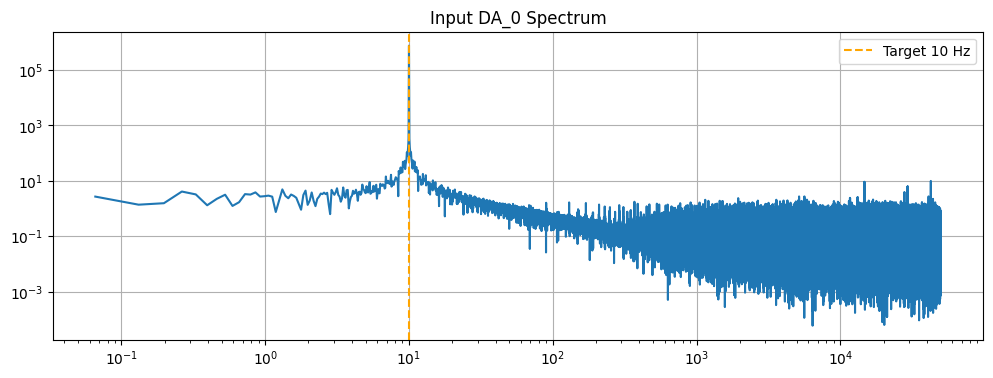

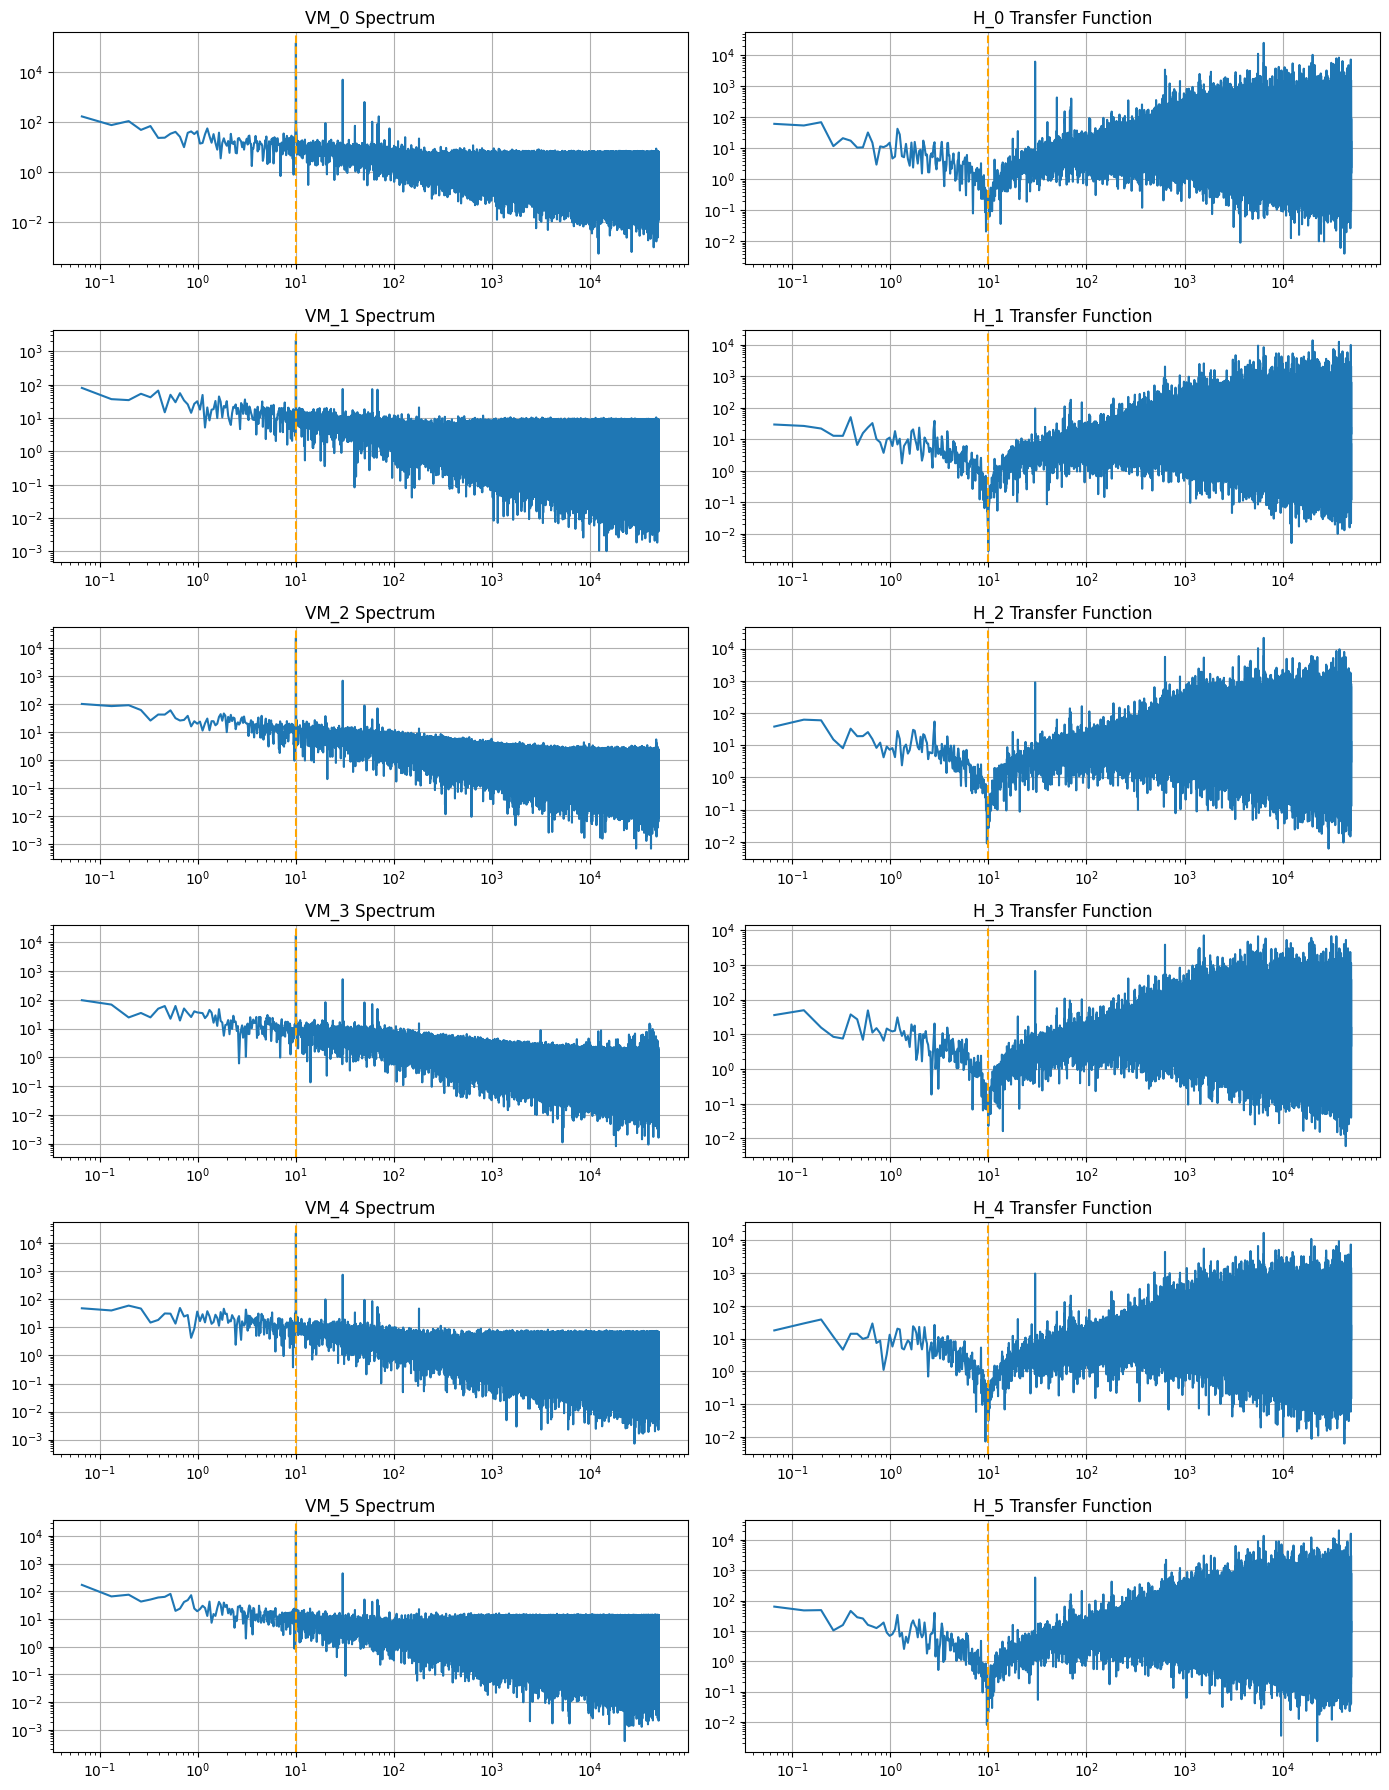


[Signed Gain Matrix] VM row × DA col
VM_0 -0.1832✓ -0.0051✓ +0.0266✓ -0.0217✓ -0.0279✓ +0.0286✓
VM_1 +0.0028✓ +0.1723✓ +0.0282✓ -0.0337✓ -0.0528✓ +0.0181✓
VM_2 +0.0305✓ -0.0215✓ -0.1606✓ -0.0043✓ -0.0158✓ +0.0288✓
VM_3 +0.0226✓ -0.0498✓ +0.0054✓ +0.1654✓ -0.0593✓ +0.0132✓
VM_4 +0.0300✓ -0.0596✓ +0.0177✓ -0.0541✓ +0.1886✓ +0.0051✓
VM_5 +0.0207✓ -0.0178✓ +0.0199✓ -0.0140✓ -0.0018✓ -0.1307✓

[Summary] 36/36 Valid (100.0%)


In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

def dac_to_voltage(dac):  # 16-bit DAC to voltage
    return (dac - 32768) * (20.0 / 65536)

def load_data(file):
    df = pd.read_csv(file)
    vm = df[[f'vm_{i}' for i in range(6)]].values.T
    da = df[[f'da_{i}' for i in range(6)]].values.T
    return {'vm': vm, 'da': da}

def find_excitation_channel(da):
    return np.argmax(np.sqrt(np.mean(da**2, axis=1)))

def detect_steady_state(file, freq, sampling_rate=100000, start_period=1, 
                        consecutive_periods=3, check_points=10, threshold=1e-3):
    df = pd.read_csv(file)
    valid = np.ones(len(df), dtype=bool)
    valid[::10000] = False
    df = df[valid].reset_index(drop=True)
    vm = df[[f'vm_{i}' for i in range(6)]].values.T
    original_idx = np.where(valid)[0]

    per_samples = int(sampling_rate / freq)
    max_periods = len(df) // per_samples
    check_pos = np.linspace(0, per_samples-1, check_points, dtype=int)
    results = []

    for ch in range(6):
        sig = vm[ch]
        for p in range(start_period, max_periods - consecutive_periods):
            if all(np.max(np.abs(sig[(p+i)*per_samples + check_pos] - sig[(p+i+1)*per_samples + check_pos])) < threshold 
                   for i in range(consecutive_periods)):
                results.append(p)
                break

    if results:
        period = max(results)
        return {'period': period, 'index': original_idx[period * per_samples], 'max_periods': max_periods}
    return None

def compute_tf(input_sig, output_sig, fs, target_freq, tol_pct=5):
    input_sig -= np.mean(input_sig)
    output_sig -= np.mean(output_sig)

    U = fft(input_sig)
    Y = fft(output_sig)
    freqs = fftfreq(len(U), 1/fs)
    pos = freqs > 0
    freqs = freqs[pos]
    U, Y = U[pos], Y[pos]

    vm_power = np.abs(Y)**2
    max_freq = freqs[np.argmax(vm_power)]
    valid = abs(max_freq - target_freq) <= target_freq * tol_pct / 100

    idx = np.argmin(np.abs(freqs - target_freq))
    H = Y[idx] / U[idx]
    return np.real(H), np.abs(H), np.angle(H, deg=True), valid

def plot_frequency_analysis(file, freq, steady, tol_pct=5):
    data = load_data(file)
    da_v = dac_to_voltage(data['da'])
    ch = find_excitation_channel(da_v)

    ps = int(100000 / freq)
    ap = steady['max_periods'] - steady['period']
    s_idx = steady['index']
    e_idx = s_idx + ap * ps
    u = da_v[ch][s_idx:e_idx]

    u_clean = u - np.mean(u)
    freqs = fftfreq(len(u), 1/100000)
    pos = freqs > 0
    freqs, U = freqs[pos], fft(u_clean)[pos]

    # Input FFT plot
    plt.figure(figsize=(12, 4))
    plt.title(f"Input DA_{ch} Spectrum")
    plt.loglog(freqs, np.abs(U))
    plt.axvline(freq, color='orange', linestyle='--', label=f'Target {freq} Hz')
    plt.grid(True)
    plt.legend()
    plt.show()

    # VM & TF plots
    fig, axs = plt.subplots(6, 2, figsize=(14, 18))
    for i in range(6):
        y = data['vm'][i][s_idx:e_idx] - np.mean(data['vm'][i][s_idx:e_idx])
        Y = fft(y)[pos]
        H = Y / U

        axs[i, 0].loglog(freqs, np.abs(Y))
        axs[i, 0].set_title(f'VM_{i} Spectrum')
        axs[i, 1].loglog(freqs, np.abs(H))
        axs[i, 1].set_title(f'H_{i} Transfer Function')
        for ax in axs[i]:
            ax.axvline(freq, color='orange', linestyle='--')
            ax.grid(True)
    plt.tight_layout()
    plt.show()

def calculate_b_matrix(csv_files, target_freq, tol_pct=5, steady_params=None, plot_file=None):
    if steady_params is None:
        steady_params = {'consecutive_periods': 3, 'check_points': 10, 'threshold': 1e-3}

    B_signed, B_mag, B_phase = np.zeros((6,6)), np.zeros((6,6)), np.zeros((6,6))
    validation = np.zeros((6,6), dtype=bool)
    steady_all = []

    for f in csv_files:
        info = detect_steady_state(f, target_freq, **steady_params)
        if not info:
            print(f"[Error] No steady state in {f}")
            return None
        steady_all.append(info)

    uni_period = max([i['period'] for i in steady_all])
    print(f"[Info] Unified Steady Period: {uni_period}")

    ps = int(100000 / target_freq)
    for i, f in enumerate(csv_files):
        data = load_data(f)
        da_v = dac_to_voltage(data['da'])
        ch = find_excitation_channel(da_v)
        info = steady_all[i]

        ap = info['max_periods'] - uni_period
        s_idx = info['index'] + (uni_period - info['period']) * ps
        e_idx = s_idx + ap * ps
        u = da_v[ch][s_idx:e_idx]

        if f == plot_file:
            plot_frequency_analysis(f, target_freq, {
                'period': uni_period, 'index': s_idx, 'max_periods': info['max_periods']
            }, tol_pct)

        for vm in range(6):
            y = data['vm'][vm][s_idx:e_idx]
            s, m, p, ok = compute_tf(u, y, 100000, target_freq, tol_pct)
            B_signed[vm, ch], B_mag[vm, ch], B_phase[vm, ch], validation[vm, ch] = s, m, p, ok

    print("\n[Signed Gain Matrix] VM row × DA col")
    for i in range(6):
        row = f"VM_{i} " + " ".join(f"{B_signed[i,j]:+7.4f}{'✓' if validation[i,j] else '✗'}" for j in range(6))
        print(row)

    passed = np.sum(validation)
    print(f"\n[Summary] {passed}/36 Valid ({passed/36*100:.1f}%)")
    return {'B_signed': B_signed, 'B_magnitude': B_mag, 'B_phase': B_phase, 'validation': validation}

# === Usage Entry Point ===
if __name__ == "__main__":
    csv_files = ['0.csv', '1.csv', '2.csv', '3.csv', '4.csv', '5.csv']
    target_freq = 10               # Hz
    tolerance_pct = 5             # ±%
    plot_file = '0.csv'           # or None
    steady_params = {
        'consecutive_periods': 2,
        'check_points': 5,
        'threshold': 2e-3
    }

    result = calculate_b_matrix(
        csv_files=csv_files,
        target_freq=target_freq,
        tol_pct=tolerance_pct,
        steady_params=steady_params,
        plot_file=plot_file
    )


# final claude

B矩陣計算: 10Hz, VM驗證容差±5%
統一穩態點: 第7週期
0.csv: DA_0, 使用152個完整週期
繪圖使用: 第7週期後的152個完整週期


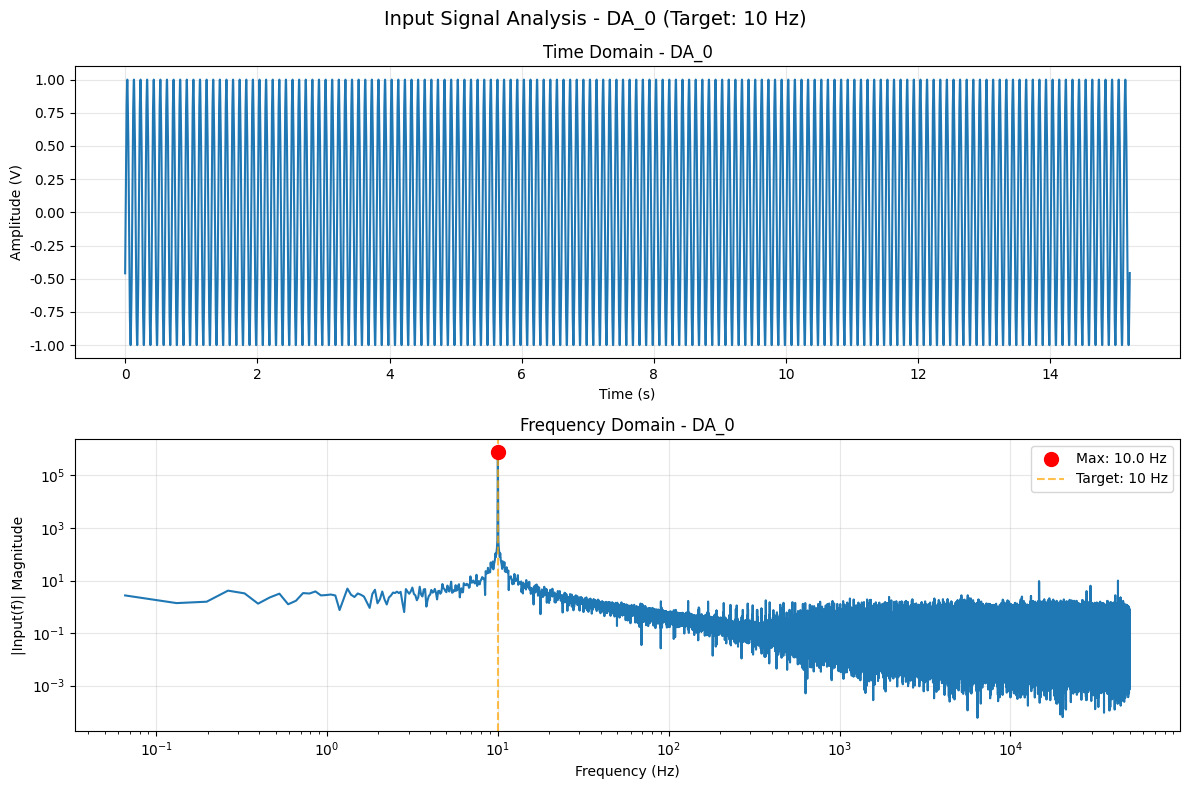

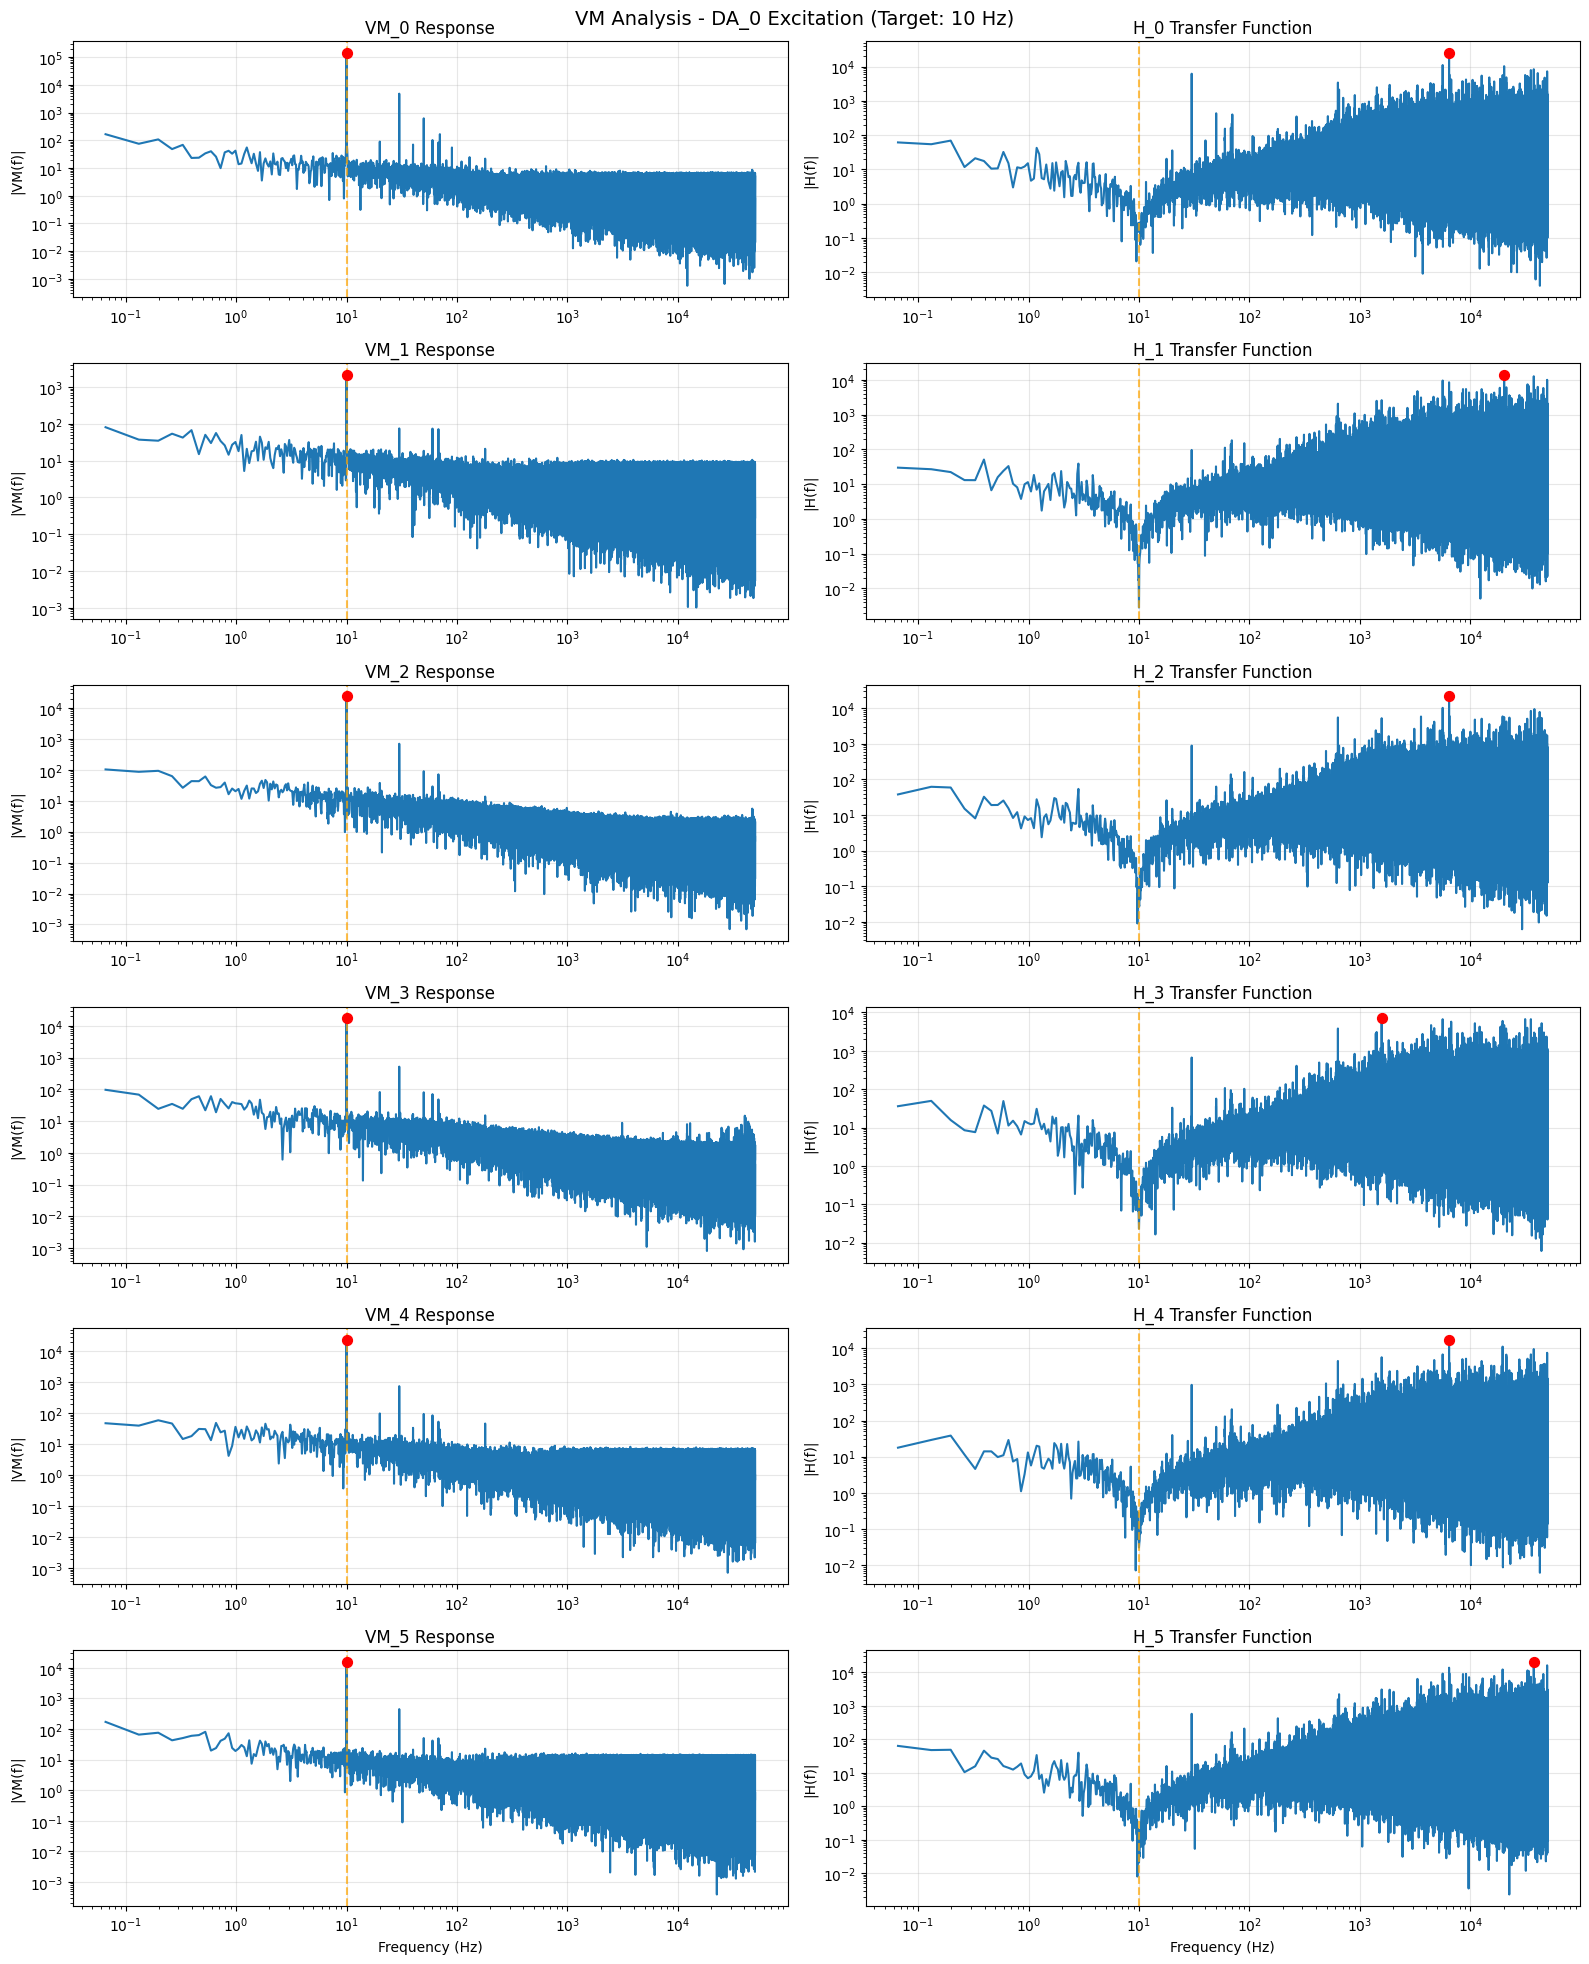

    VM最大能量@10.00Hz (誤差0.0%) ✓
    VM最大能量@10.00Hz (誤差0.0%) ✓
    VM最大能量@10.00Hz (誤差0.0%) ✓
    VM最大能量@10.00Hz (誤差0.0%) ✓
    VM最大能量@10.00Hz (誤差0.0%) ✓
    VM最大能量@10.00Hz (誤差0.0%) ✓
1.csv: DA_1, 使用151個完整週期
    VM最大能量@10.00Hz (誤差0.0%) ✓
    VM最大能量@10.00Hz (誤差0.0%) ✓
    VM最大能量@10.00Hz (誤差0.0%) ✓
    VM最大能量@10.00Hz (誤差0.0%) ✓
    VM最大能量@10.00Hz (誤差0.0%) ✓
    VM最大能量@10.00Hz (誤差0.0%) ✓
2.csv: DA_2, 使用150個完整週期
    VM最大能量@10.00Hz (誤差0.0%) ✓
    VM最大能量@10.00Hz (誤差0.0%) ✓
    VM最大能量@10.00Hz (誤差0.0%) ✓
    VM最大能量@10.00Hz (誤差0.0%) ✓
    VM最大能量@10.00Hz (誤差0.0%) ✓
    VM最大能量@10.00Hz (誤差0.0%) ✓
3.csv: DA_3, 使用150個完整週期
    VM最大能量@10.00Hz (誤差0.0%) ✓
    VM最大能量@10.00Hz (誤差0.0%) ✓
    VM最大能量@10.00Hz (誤差0.0%) ✓
    VM最大能量@10.00Hz (誤差0.0%) ✓
    VM最大能量@10.00Hz (誤差0.0%) ✓
    VM最大能量@10.00Hz (誤差0.0%) ✓
4.csv: DA_4, 使用151個完整週期
    VM最大能量@10.00Hz (誤差0.0%) ✓
    VM最大能量@10.00Hz (誤差0.0%) ✓
    VM最大能量@10.00Hz (誤差0.0%) ✓
    VM最大能量@10.00Hz (誤差0.0%) ✓
    VM最大能量@10.00Hz (誤差0.0%) ✓
    VM最大能量@10.00Hz (誤差0.0%) ✓
5.cs

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

def dac_to_voltage(dac_value):
    """將16位元DAC數值轉換為電壓"""
    return (dac_value - 32768) * (20.0 / 65536)

def load_single_test(csv_file):
    """載入CSV測試數據"""
    df = pd.read_csv(csv_file)
    vm = df[['vm_0', 'vm_1', 'vm_2', 'vm_3', 'vm_4', 'vm_5']].values.T
    da = df[['da_0', 'da_1', 'da_2', 'da_3', 'da_4', 'da_5']].values.T
    return {'vm': vm, 'da': da}

def find_excitation_channel(da_data):
    """找出激勵通道"""
    da_rms = np.sqrt(np.mean(da_data**2, axis=1))
    return np.argmax(da_rms)

def detect_steady_state_by_periods(csv_file, target_freq, sampling_rate=100000,
                                 start_period=1, consecutive_periods=3, 
                                 check_points=10, threshold=1e-3):
    """檢測穩態起始週期"""
    
    df = pd.read_csv(csv_file)
    exclude_indices = np.arange(0, len(df), 10000)
    valid_mask = np.ones(len(df), dtype=bool)
    valid_mask[exclude_indices] = False
    
    valid_df = df[valid_mask].reset_index(drop=True)
    vm_data = valid_df[['vm_0', 'vm_1', 'vm_2', 'vm_3', 'vm_4', 'vm_5']].values.T
    original_indices = np.where(valid_mask)[0]
    
    period_samples = int(sampling_rate / target_freq)
    max_periods = len(valid_df) // period_samples
    check_positions = np.linspace(0, period_samples-1, check_points, dtype=int)
    
    steady_periods = []
    
    for vm_ch in range(6):
        signal = vm_data[vm_ch]
        
        for test_period in range(start_period, max_periods - consecutive_periods):
            all_stable = True
            
            for i in range(consecutive_periods):
                current_period = test_period + i
                next_period = current_period + 1
                
                current_start = current_period * period_samples
                next_start = next_period * period_samples
                
                max_diff = 0
                for pos in check_positions:
                    current_val = signal[current_start + pos]
                    next_val = signal[next_start + pos]
                    diff = abs(current_val - next_val)
                    max_diff = max(max_diff, diff)
                
                if max_diff >= threshold:
                    all_stable = False
                    break
            
            if all_stable:
                steady_periods.append(test_period)
                break
    
    if steady_periods:
        recommended_period = max(steady_periods)
        valid_index = recommended_period * period_samples
        original_index = original_indices[valid_index]
        
        return {
            'period': recommended_period,
            'index': original_index,
            'max_periods': max_periods
        }
    
    return None

def calculate_transfer_function_with_validation(input_signal, output_signal, fs, target_freq, 
                                              tolerance_percent=5):
    """計算傳遞函數並驗證VM響應的最大能量點"""
    
    # 去除DC分量，無需窗函數（完整週期）
    input_clean = input_signal - np.mean(input_signal)
    output_clean = output_signal - np.mean(output_signal)
    
    # FFT計算
    input_fft = fft(input_clean)
    output_fft = fft(output_clean)
    freqs = fftfreq(len(input_clean), 1/fs)
    
    # 正頻率範圍
    positive_mask = freqs > 0
    positive_freqs = freqs[positive_mask]
    positive_input_fft = input_fft[positive_mask]
    positive_output_fft = output_fft[positive_mask]
    
    # VM響應驗證：找最大能量點
    vm_power = np.abs(positive_output_fft)**2
    max_energy_idx = np.argmax(vm_power)
    vm_max_freq = positive_freqs[max_energy_idx]
    
    # 計算容差範圍
    tolerance = target_freq * tolerance_percent / 100
    freq_range = [target_freq - tolerance, target_freq + tolerance]
    
    # 驗證最大能量點是否在範圍內
    is_valid = freq_range[0] <= vm_max_freq <= freq_range[1]
    
    # 計算目標頻率處的傳遞函數
    target_idx = np.argmin(np.abs(positive_freqs - target_freq))
    H_complex = positive_output_fft[target_idx] / positive_input_fft[target_idx]
    
    signed_gain = np.real(H_complex)
    magnitude = np.abs(H_complex)
    phase_deg = np.angle(H_complex) * 180 / np.pi
    
    freq_error_percent = abs(vm_max_freq - target_freq) / target_freq * 100
    print(f"    VM最大能量@{vm_max_freq:.2f}Hz (誤差{freq_error_percent:.1f}%) {'✓' if is_valid else '✗'}")
    
    return signed_gain, magnitude, phase_deg, is_valid

def plot_frequency_analysis(csv_file, target_freq, steady_info, tolerance_percent=5):
    """繪製頻域分析圖"""
    
    data = load_single_test(csv_file)
    da_voltage = dac_to_voltage(data['da'])
    excited_ch = find_excitation_channel(da_voltage)
    
    # 計算穩態後的完整週期數據
    period_samples = int(100000 / target_freq)
    steady_period = steady_info['period']
    max_periods = steady_info['max_periods']
    available_periods = max_periods - steady_period
    
    start_idx = steady_info['index']
    end_idx = start_idx + available_periods * period_samples
    
    input_signal = da_voltage[excited_ch][start_idx:end_idx]
    
    print(f"繪圖使用: 第{steady_period}週期後的{available_periods}個完整週期")
    
    # 預處理和FFT
    input_clean = input_signal - np.mean(input_signal)
    input_fft = fft(input_clean)
    freqs = fftfreq(len(input_clean), 1/100000)
    
    positive_mask = freqs > 0
    freqs_pos = freqs[positive_mask]
    input_fft_pos = input_fft[positive_mask]
    
    # === 輸入信號分析圖 ===
    fig_input, (ax_time, ax_freq) = plt.subplots(2, 1, figsize=(12, 8))
    fig_input.suptitle(f'Input Signal Analysis - DA_{excited_ch} (Target: {target_freq} Hz)', fontsize=14)
    
    # 時域圖
    time_axis = np.arange(len(input_signal)) / 100000
    ax_time.plot(time_axis, input_signal)
    ax_time.set_xlabel('Time (s)')
    ax_time.set_ylabel('Amplitude (V)')
    ax_time.set_title(f'Time Domain - DA_{excited_ch}')
    ax_time.grid(True, alpha=0.3)
    
    # 頻域圖
    input_magnitude = np.abs(input_fft_pos)
    max_input_idx = np.argmax(input_magnitude)
    max_input_freq = freqs_pos[max_input_idx]
    
    ax_freq.loglog(freqs_pos, input_magnitude)
    ax_freq.scatter(max_input_freq, input_magnitude[max_input_idx], color='red', s=100, zorder=5,
                    label=f'Max: {max_input_freq:.1f} Hz')
    ax_freq.axvline(target_freq, color='orange', linestyle='--', alpha=0.7, 
                    label=f'Target: {target_freq} Hz')
    ax_freq.set_xlabel('Frequency (Hz)')
    ax_freq.set_ylabel('|Input(f)| Magnitude')
    ax_freq.set_title(f'Frequency Domain - DA_{excited_ch}')
    ax_freq.grid(True, alpha=0.3)
    ax_freq.legend()
    
    plt.tight_layout()
    plt.show()
    
    # === VM通道分析圖 ===
    fig, axes = plt.subplots(6, 2, figsize=(16, 20))
    fig.suptitle(f'VM Analysis - DA_{excited_ch} Excitation (Target: {target_freq} Hz)', fontsize=14)
    
    for vm_ch in range(6):
        output_signal = data['vm'][vm_ch][start_idx:end_idx]
        
        # 預處理和FFT
        output_clean = output_signal - np.mean(output_signal)
        output_fft = fft(output_clean)
        output_fft_pos = output_fft[positive_mask]
        
        # 計算傳遞函數
        valid_mask = np.abs(input_fft_pos) > 1e-10
        H_complex = np.zeros_like(input_fft_pos, dtype=complex)
        H_complex[valid_mask] = output_fft_pos[valid_mask] / input_fft_pos[valid_mask]
        
        # VM響應頻譜
        vm_magnitude = np.abs(output_fft_pos)
        max_vm_idx = np.argmax(vm_magnitude)
        max_vm_freq = freqs_pos[max_vm_idx]
        
        axes[vm_ch, 0].loglog(freqs_pos, vm_magnitude)
        axes[vm_ch, 0].scatter(max_vm_freq, vm_magnitude[max_vm_idx], color='red', s=50, zorder=5)
        axes[vm_ch, 0].axvline(target_freq, color='orange', linestyle='--', alpha=0.7)
        axes[vm_ch, 0].set_title(f'VM_{vm_ch} Response')
        axes[vm_ch, 0].set_ylabel('|VM(f)|')
        axes[vm_ch, 0].grid(True, alpha=0.3)
        
        # 傳遞函數頻譜
        H_magnitude = np.abs(H_complex)
        freqs_valid = freqs_pos[valid_mask]
        max_h_idx = np.argmax(H_magnitude[valid_mask])
        max_h_freq = freqs_valid[max_h_idx]
        
        axes[vm_ch, 1].loglog(freqs_valid, H_magnitude[valid_mask])
        axes[vm_ch, 1].scatter(max_h_freq, H_magnitude[valid_mask][max_h_idx], color='red', s=50, zorder=5)
        axes[vm_ch, 1].axvline(target_freq, color='orange', linestyle='--', alpha=0.7)
        axes[vm_ch, 1].set_title(f'H_{vm_ch} Transfer Function')
        axes[vm_ch, 1].set_ylabel('|H(f)|')
        axes[vm_ch, 1].grid(True, alpha=0.3)
        
        if vm_ch == 5:  # 最後一行添加x軸標籤
            axes[vm_ch, 0].set_xlabel('Frequency (Hz)')
            axes[vm_ch, 1].set_xlabel('Frequency (Hz)')
    
    plt.tight_layout()
    plt.show()

def calculate_b_matrix_integrated(csv_files, target_freq, tolerance_percent=5,
                                steady_params=None, plot_file=None):
    """
    整合計算B矩陣
    
    Parameters:
    ----------
    tolerance_percent : float, VM驗證容差百分比
    plot_file : str or None, 要繪圖的檔案名稱，None表示不繪圖
    """
    
    if steady_params is None:
        steady_params = {
            'consecutive_periods': 3,
            'check_points': 10,
            'threshold': 1e-3
        }
    
    print(f"B矩陣計算: {target_freq}Hz, VM驗證容差±{tolerance_percent}%")
    
    # === 統一穩態檢測 ===
    all_steady_info = []
    
    for csv_file in csv_files:
        result = detect_steady_state_by_periods(csv_file, target_freq, **steady_params)
        if result:
            all_steady_info.append(result)
        else:
            print(f"錯誤: {csv_file} 未檢測到穩態")
            return None
    
    # 使用最保守的穩態點
    unified_steady_period = max([info['period'] for info in all_steady_info])
    print(f"統一穩態點: 第{unified_steady_period}週期")
    
    # === B矩陣計算 ===
    period_samples = int(100000 / target_freq)
    B_signed = np.zeros((6, 6))
    B_magnitude = np.zeros((6, 6))
    B_phase = np.zeros((6, 6))
    validation_results = np.zeros((6, 6), dtype=bool)
    
    for i, csv_file in enumerate(csv_files):
        data = load_single_test(csv_file)
        da_voltage = dac_to_voltage(data['da'])
        excited_ch = find_excitation_channel(da_voltage)
        
        # 計算可用的完整週期數
        steady_info = all_steady_info[i]
        available_periods = steady_info['max_periods'] - unified_steady_period
        
        start_idx = steady_info['index'] + (unified_steady_period - steady_info['period']) * period_samples
        end_idx = start_idx + available_periods * period_samples
        
        input_signal = da_voltage[excited_ch][start_idx:end_idx]
        
        print(f"{csv_file}: DA_{excited_ch}, 使用{available_periods}個完整週期")
        
        # === 繪圖 ===
        if plot_file == csv_file:
            plot_frequency_analysis(csv_file, target_freq, 
                                   {'period': unified_steady_period, 'index': start_idx, 
                                    'max_periods': steady_info['max_periods']}, 
                                   tolerance_percent)
        
        for vm_ch in range(6):
            output_signal = data['vm'][vm_ch][start_idx:end_idx]
            
            signed_gain, magnitude, phase_deg, is_valid = calculate_transfer_function_with_validation(
                input_signal, output_signal, 100000, target_freq, tolerance_percent
            )
            
            B_signed[vm_ch, excited_ch] = signed_gain
            B_magnitude[vm_ch, excited_ch] = magnitude
            B_phase[vm_ch, excited_ch] = phase_deg
            validation_results[vm_ch, excited_ch] = is_valid
    
    # === 顯示結果 ===
    print(f"\n含符號B矩陣 (VM行×DA列):")
    print("=" * 50)
    print("        DA_0     DA_1     DA_2     DA_3     DA_4     DA_5")
    for i in range(6):
        row_str = f"VM_{i}  "
        for j in range(6):
            valid_mark = "✓" if validation_results[i, j] else "✗"
            row_str += f"{B_signed[i, j]:+7.4f}{valid_mark} "
        print(row_str)
    
    print(f"\n幅值矩陣:")
    print(B_magnitude)
    
    print(f"\n相位矩陣 (度):")
    print(B_phase)
    
    total_valid = np.sum(validation_results)
    print(f"\n驗證統計: {total_valid}/36 通過 ({total_valid/36*100:.1f}%)")
    
    return {
        'B_signed': B_signed,
        'B_magnitude': B_magnitude,
        'B_phase': B_phase,
        'validation_results': validation_results
    }

# === 使用範例 ===
if __name__ == "__main__":
    
    csv_files = ['0.csv', '1.csv', '2.csv', '3.csv', '4.csv', '5.csv']
    
    # 穩態檢測參數
    steady_params = {
        'consecutive_periods': 2,
        'check_points': 5,
        'threshold': 2e-3
    }
    
    # 計算B矩陣並繪製指定檔案的圖形
    result = calculate_b_matrix_integrated(
        csv_files=csv_files,
        target_freq=10,              # 目標頻率
        tolerance_percent=5,        # VM驗證容差 ±10%
        steady_params=steady_params,
        plot_file='0.csv'           # 繪製0.csv的圖形，設為None不繪圖
    )